In [58]:
!pip install fbprophet

In [59]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [60]:
Pop = pd.read_csv("/content/TM.csv")
Pop=Pop.iloc[pd.to_datetime(Pop.Date.astype(str)).argsort()]
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0
...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3


**Pour le prix**

In [61]:
dfP = Pop[["Date","prix moyen au kg"]]
dfP

,Date,prix moyen au kg
354,01/08/12,1.30
333,01/10/12,1.10
332,02/10/12,1.10
353,03/08/12,1.25
342,04/09/12,1.10
...,...,...
388,11/09/20,1.75
19,11/09/20,1.05
373,19/11/20,1.80
372,20/11/20,1.50


In [62]:
dfP['ds'] = pd.to_datetime(dfP['Date'],infer_datetime_format=True, dayfirst= True)
dfP['y'] = dfP['prix moyen au kg']
dfP = dfP.drop(["Date","prix moyen au kg"], axis=1)
dfP

,ds,y
354,2012-08-01,1.30
333,2012-10-01,1.10
332,2012-10-02,1.10
353,2012-08-03,1.25
342,2012-09-04,1.10
...,...,...
388,2020-09-11,1.75
19,2020-09-11,1.05
373,2020-11-19,1.80
372,2020-11-20,1.50


In [63]:
from fbprophet import Prophet
m1 = Prophet(daily_seasonality=True)
m1.fit(dfP)

In [64]:
future1 = m1.make_future_dataframe(periods=7, freq='D')
predictions=m1.predict(future1)

In [65]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,1.681639,1.433373,1.930283
401,2021-06-23,1.660132,1.434694,1.890739
402,2021-06-24,1.676705,1.438789,1.921838
403,2021-06-25,1.671665,1.434769,1.935569
404,2021-06-26,1.708716,1.469022,1.940456
405,2021-06-27,1.705565,1.463101,1.943378
406,2021-06-28,1.625655,1.393803,1.877093


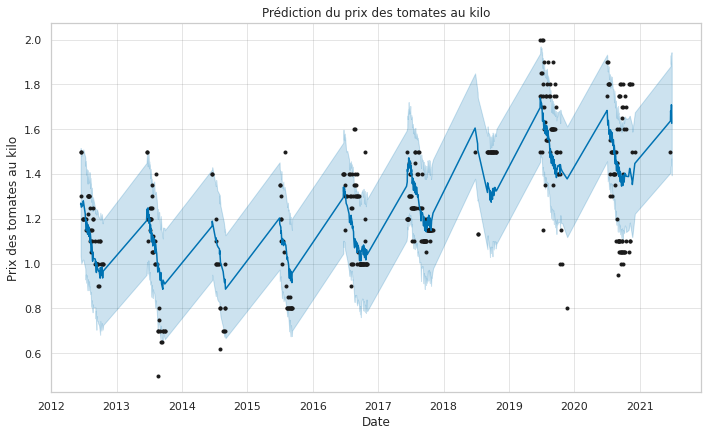

In [66]:
m1.plot(predictions)
plt.title("Prédiction du prix des tomates au kilo")
plt.xlabel("Date")
plt.ylabel("Prix des tomates au kilo")
plt.show()

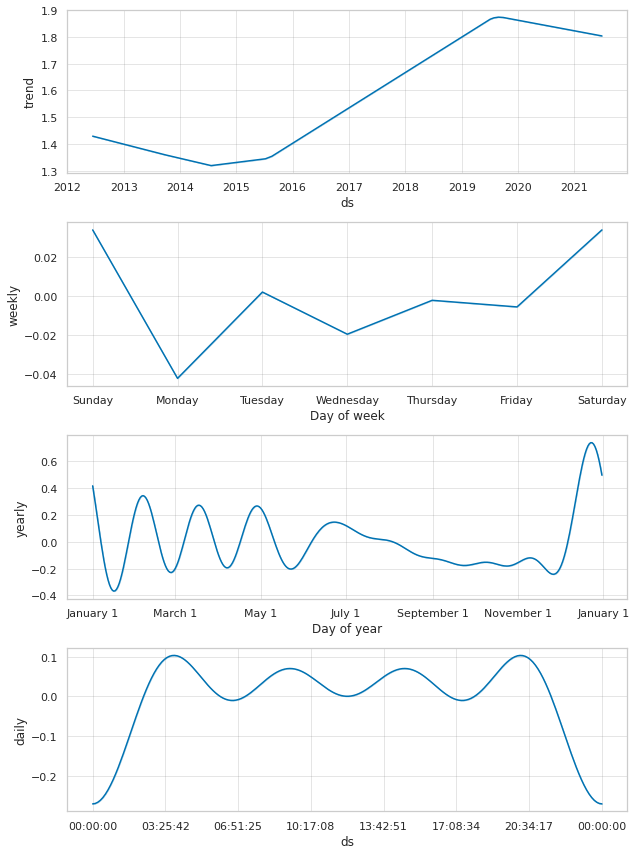

In [67]:
m1.plot_components(predictions)
plt.show()

In [68]:
metric_df = predictions.set_index('ds')[['yhat']].join(dfP.set_index('ds').y).reset_index()
metric_df

,ds,yhat,y
0,2012-06-14,1.263972,1.5
1,2012-06-15,1.269332,1.5
2,2012-06-18,1.251635,1.3
3,2012-06-25,1.257881,1.2
4,2012-06-29,1.279921,1.2
...,...,...,...
426,2021-06-24,1.676705,NaN
427,2021-06-25,1.671665,NaN
428,2021-06-26,1.708716,NaN
429,2021-06-27,1.705565,NaN


In [69]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
419,2020-11-06,1.424749,1.1
420,2020-11-19,1.367644,1.8
421,2020-11-20,1.352500,1.5
422,2020-12-04,1.446576,1.5
423,2021-06-21,1.636326,1.5


In [70]:
from sklearn.metrics import mean_squared_error, r2_score
R2P = r2_score(metric_df.y, metric_df.yhat)
R2P

0.5579023916956132

In [71]:
from math import sqrt

rmseP =sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmseP)

0.19143119371940867


In [72]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.15155300789916823

**Pour la production**

In [73]:
dfPo = Pop[["Date","Production quantité \ntonne(s)"]]
dfPo

,Date,Production quantité \ntonne(s)
354,01/08/12,0.20
333,01/10/12,0.20
332,02/10/12,0.20
353,03/08/12,0.30
342,04/09/12,0.40
...,...,...
388,11/09/20,0.50
19,11/09/20,0.50
373,19/11/20,0.05
372,20/11/20,0.10


In [74]:
dfPo['ds'] = pd.to_datetime(dfPo['Date'],infer_datetime_format=True, dayfirst= True)
dfPo['y'] = dfPo['Production quantité \ntonne(s)']
dfPo = dfPo.drop(["Date","Production quantité \ntonne(s)"], axis=1)
dfPo

,ds,y
354,2012-08-01,0.20
333,2012-10-01,0.20
332,2012-10-02,0.20
353,2012-08-03,0.30
342,2012-09-04,0.40
...,...,...
388,2020-09-11,0.50
19,2020-09-11,0.50
373,2020-11-19,0.05
372,2020-11-20,0.10


In [75]:
m2 = Prophet(daily_seasonality=True)
m2.fit(dfPo)

In [76]:
future2 = m2.make_future_dataframe(periods=7, freq='D')
predictions2=m2.predict(future2)

In [77]:
predictions2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.395465,-1.264075,0.427857
401,2021-06-23,-0.154134,-1.037130,0.718292
402,2021-06-24,0.368556,-0.456957,1.223413
403,2021-06-25,-0.010952,-0.825969,0.851806
404,2021-06-26,0.026806,-0.728833,0.859539
405,2021-06-27,0.072476,-0.785836,0.985452
406,2021-06-28,0.364407,-0.490868,1.188211


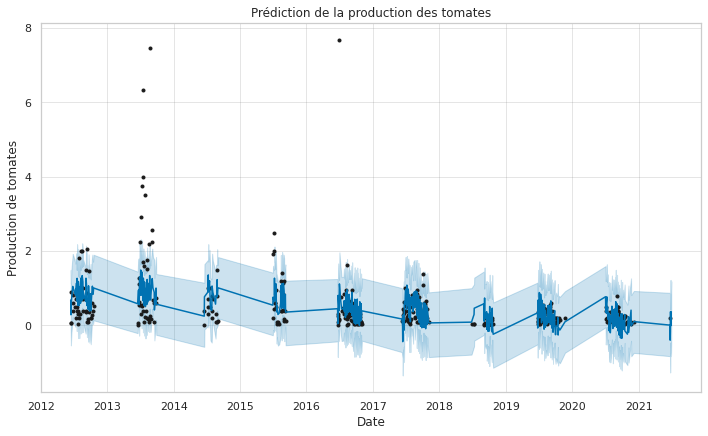

In [78]:
m2.plot(predictions2)
plt.title("Prédiction de la production des tomates")
plt.xlabel("Date")
plt.ylabel("Production de tomates")
plt.show()

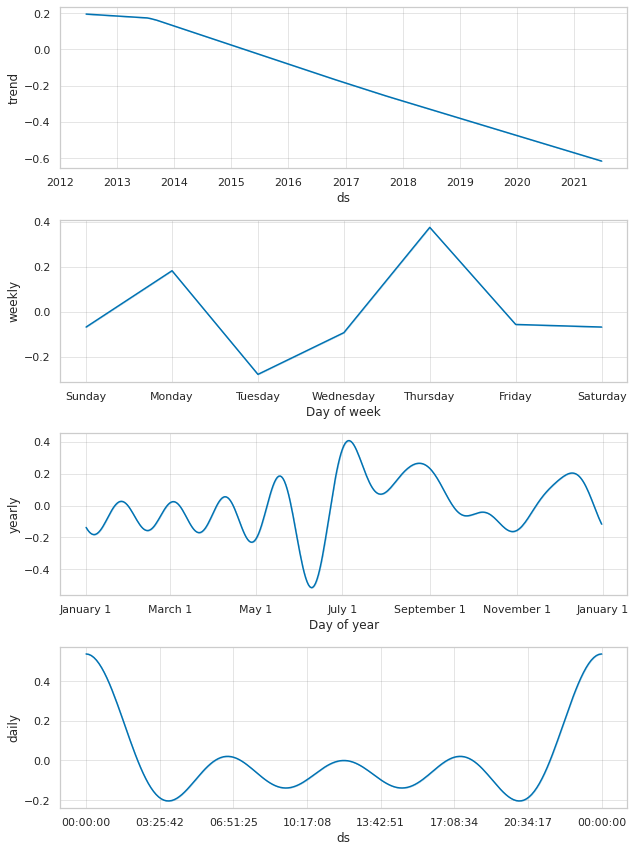

In [79]:
m2.plot_components(predictions2)
plt.show()

In [80]:
metric_df2 = predictions2.set_index('ds')[['yhat']].join(dfPo.set_index('ds').y).reset_index()
metric_df2

,ds,yhat,y
0,2012-06-14,0.681359,0.06
1,2012-06-15,0.286778,0.07
2,2012-06-18,0.665586,0.90
3,2012-06-25,1.049108,0.83
4,2012-06-29,0.980054,0.60
...,...,...,...
426,2021-06-24,0.368556,NaN
427,2021-06-25,-0.010952,NaN
428,2021-06-26,0.026806,NaN
429,2021-06-27,0.072476,NaN


In [81]:
metric_df2.dropna(inplace=True)
metric_df2.tail()

,ds,yhat,y
419,2020-11-06,-0.186811,0.10
420,2020-11-19,0.411165,0.05
421,2020-11-20,-0.009705,0.10
422,2020-12-04,0.103690,0.10
423,2021-06-21,0.009033,0.20


In [82]:
R2Po = r2_score(metric_df2.y, metric_df2.yhat)
R2Po

0.2681334345184202

In [83]:
rmsePo =sqrt(mean_squared_error(metric_df2.y, metric_df2.yhat))
print(rmsePo)

0.6637481153894874


In [84]:
mean_absolute_error(metric_df2.y, metric_df2.yhat)

0.34995375001023926

**Météo future**

In [85]:
#la température minimale

dfTm = Pop[["Date","Température minimale en °C"]]
dfTm

,Date,Température minimale en °C
354,01/08/12,11.8
333,01/10/12,3.5
332,02/10/12,12.8
353,03/08/12,12.0
342,04/09/12,12.8
...,...,...
388,11/09/20,14.1
19,11/09/20,14.1
373,19/11/20,5.8
372,20/11/20,-0.1


In [86]:
dfTm['ds'] = pd.to_datetime(dfTm['Date'],infer_datetime_format=True, dayfirst= True)
dfTm['y'] = dfTm['Température minimale en °C']
dfTm = dfTm.drop(["Date","Température minimale en °C"], axis=1)
dfTm

,ds,y
354,2012-08-01,11.8
333,2012-10-01,3.5
332,2012-10-02,12.8
353,2012-08-03,12.0
342,2012-09-04,12.8
...,...,...
388,2020-09-11,14.1
19,2020-09-11,14.1
373,2020-11-19,5.8
372,2020-11-20,-0.1


In [87]:
m3 = Prophet(daily_seasonality=True)
m3.fit(dfTm)

In [88]:
future3 = m3.make_future_dataframe(periods=7, freq='D')
predictions3=m3.predict(future3)

In [89]:
predictions3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,15.797543,11.826525,19.705934
401,2021-06-23,16.191901,12.145653,20.333244
402,2021-06-24,16.025044,12.105543,20.060507
403,2021-06-25,15.519628,11.260931,19.434205
404,2021-06-26,15.158861,11.283746,18.926313
405,2021-06-27,14.871623,10.856380,18.573466
406,2021-06-28,13.794978,9.690707,17.674147


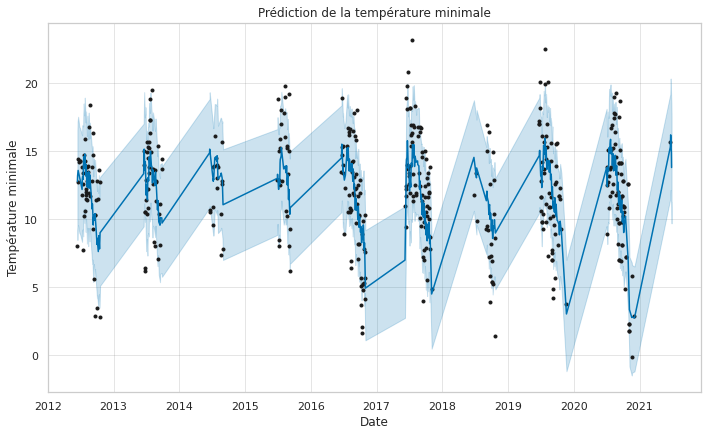

In [90]:
m3.plot(predictions3)
plt.title("Prédiction de la température minimale")
plt.xlabel("Date")
plt.ylabel("Température minimale")
plt.show()

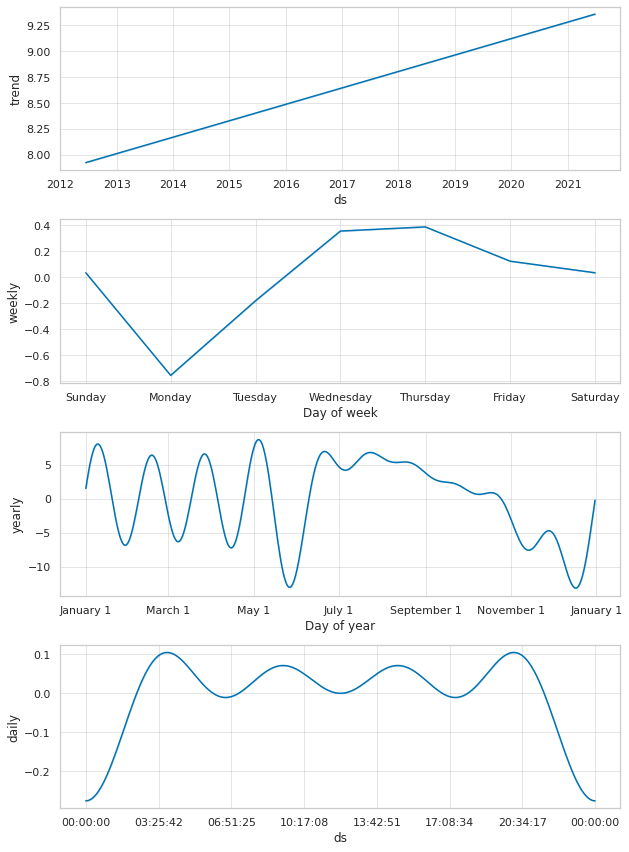

In [91]:
m3.plot_components(predictions3)
plt.show()

In [92]:
#température maximale

dfTM = Pop[["Date","Température maximale en °C"]]
dfTM

,Date,Température maximale en °C
354,01/08/12,28.0
333,01/10/12,19.1
332,02/10/12,18.8
353,03/08/12,24.1
342,04/09/12,25.7
...,...,...
388,11/09/20,28.2
19,11/09/20,28.2
373,19/11/20,11.5
372,20/11/20,10.6


In [93]:
dfTM['ds'] = pd.to_datetime(dfTM['Date'],infer_datetime_format=True, dayfirst= True)
dfTM['y'] = dfTM['Température maximale en °C']
dfTM = dfTM.drop(["Date","Température maximale en °C"], axis=1)
dfTM

,ds,y
354,2012-08-01,28.0
333,2012-10-01,19.1
332,2012-10-02,18.8
353,2012-08-03,24.1
342,2012-09-04,25.7
...,...,...
388,2020-09-11,28.2
19,2020-09-11,28.2
373,2020-11-19,11.5
372,2020-11-20,10.6


In [94]:
m4 = Prophet(daily_seasonality=True)
m4.fit(dfTM)

In [95]:
future4 = m4.make_future_dataframe(periods=7, freq='D')
predictions4=m4.predict(future4)

In [96]:
predictions4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,28.764415,23.119369,33.992109
401,2021-06-23,29.345108,23.876463,34.961761
402,2021-06-24,28.547911,22.646765,34.108290
403,2021-06-25,28.149123,22.842399,33.898001
404,2021-06-26,28.786451,23.240151,34.124650
405,2021-06-27,28.599506,22.849490,33.970841
406,2021-06-28,27.616413,21.783045,32.892689


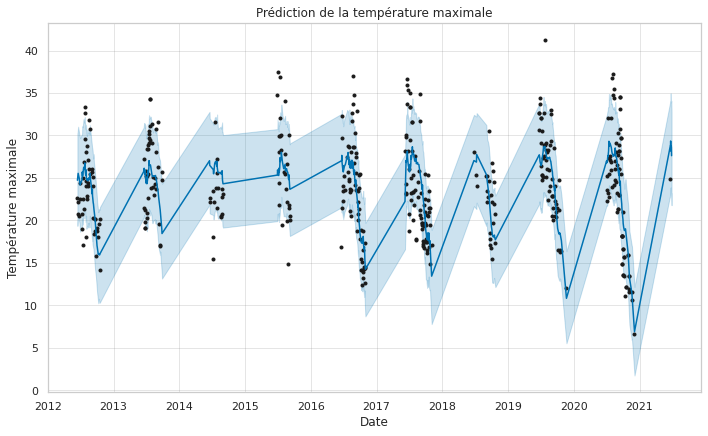

In [97]:
m4.plot(predictions4)
plt.title("Prédiction de la température maximale")
plt.xlabel("Date")
plt.ylabel("Température maximale")
plt.show()

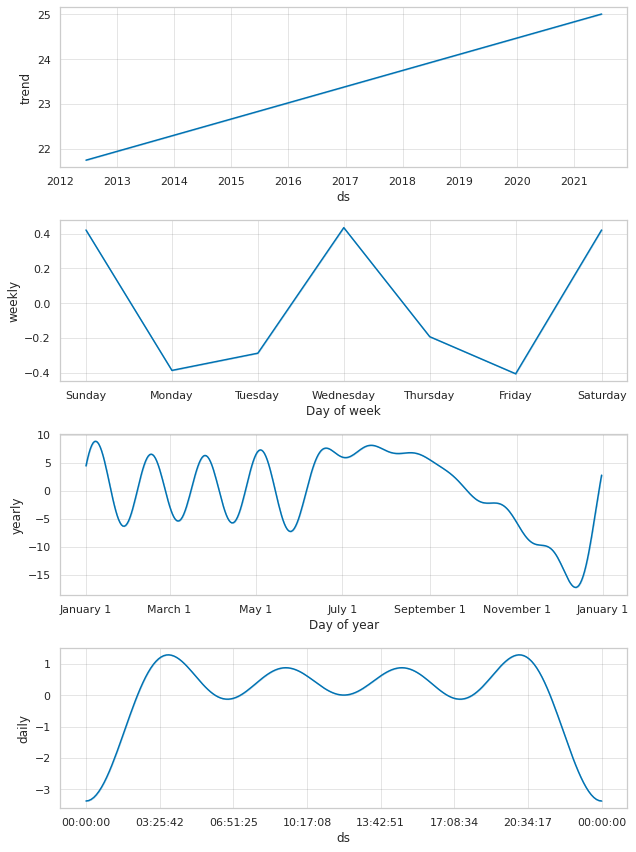

In [98]:
m4.plot_components(predictions4)
plt.show()

In [99]:
# les précipitations

dfp = Pop[["Date","précipitations en mm"]]
dfp

,Date,précipitations en mm
354,01/08/12,0.4
333,01/10/12,0.8
332,02/10/12,0.2
353,03/08/12,0.4
342,04/09/12,0.0
...,...,...
388,11/09/20,0.0
19,11/09/20,0.0
373,19/11/20,0.0
372,20/11/20,0.0


In [100]:
dfp['ds'] = pd.to_datetime(dfp['Date'],infer_datetime_format=True, dayfirst= True)
dfp['y'] = dfp['précipitations en mm']
dfp = dfp.drop(["Date","précipitations en mm"], axis=1)
dfp

,ds,y
354,2012-08-01,0.4
333,2012-10-01,0.8
332,2012-10-02,0.2
353,2012-08-03,0.4
342,2012-09-04,0.0
...,...,...
388,2020-09-11,0.0
19,2020-09-11,0.0
373,2020-11-19,0.0
372,2020-11-20,0.0


In [101]:
m5 = Prophet(daily_seasonality=True)
m5.fit(dfp)

future5 = m5.make_future_dataframe(periods=7, freq='D')
predictions5=m5.predict(future5)

predictions5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-1.230304,-6.892103,4.440535
401,2021-06-23,-0.395687,-5.936566,5.141034
402,2021-06-24,0.419739,-5.016747,5.725605
403,2021-06-25,0.093736,-5.119319,5.682556
404,2021-06-26,-0.509463,-5.982586,4.920977
405,2021-06-27,-0.501671,-6.231742,4.645552
406,2021-06-28,-1.010614,-6.543193,4.765912


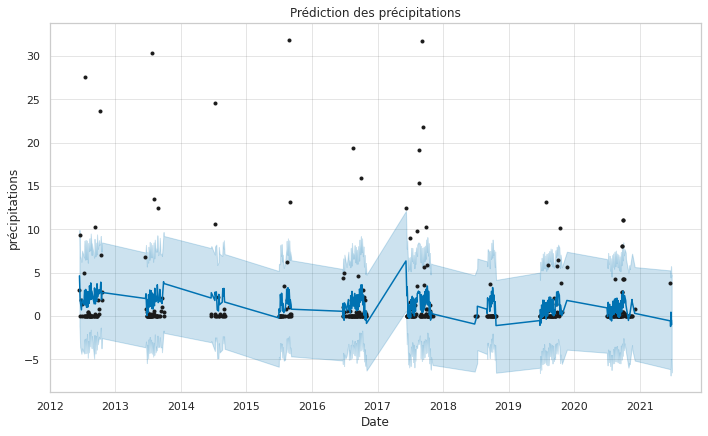

In [102]:
m5.plot(predictions5)
plt.title("Prédiction des précipitations")
plt.xlabel("Date")
plt.ylabel("précipitations")
plt.show()

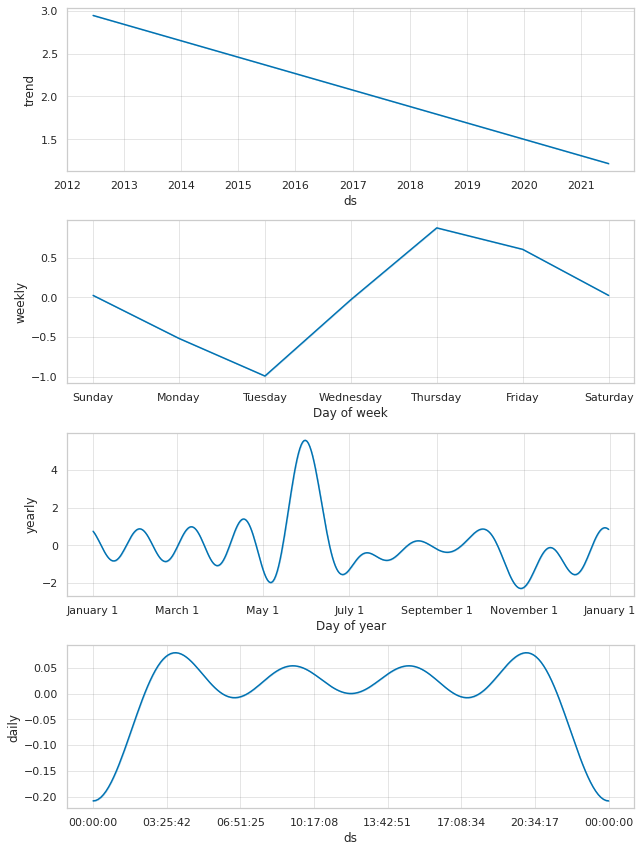

In [103]:
m5.plot_components(predictions5)
plt.show()

In [104]:
#ensoleillement

dfE = Pop[["Date","Ensoleillement en min"]]

dfE['ds'] = pd.to_datetime(dfE['Date'])
dfE['y'] = dfE['Ensoleillement en min']
dfE = dfE.drop(["Date","Ensoleillement en min"], axis=1)
dfE

,ds,y
354,2012-01-08,445
333,2012-01-10,536
332,2012-02-10,121
353,2012-03-08,330
342,2012-04-09,672
...,...,...
388,2020-11-09,552
19,2020-11-09,552
373,2020-11-19,352
372,2020-11-20,297


In [105]:
m6 = Prophet(daily_seasonality=True)
m6.fit(dfE)

future6 = m6.make_future_dataframe(periods=7, freq='D')
predictions6=m6.predict(future6)

predictions6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,578.860623,273.252135,886.001923
401,2021-06-23,577.989268,252.292613,887.064850
402,2021-06-24,519.106653,204.776887,838.174383
403,2021-06-25,483.341494,170.227758,798.836766
404,2021-06-26,607.245217,279.345549,923.121787
405,2021-06-27,439.553676,127.542454,749.411876
406,2021-06-28,526.113999,210.370611,837.126827


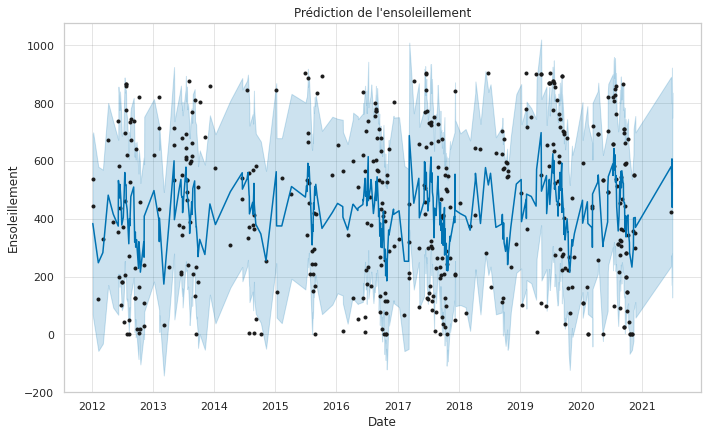

In [106]:
m6.plot(predictions6)
plt.title("Prédiction de l'ensoleillement")
plt.xlabel("Date")
plt.ylabel("Ensoleillement")
plt.show()

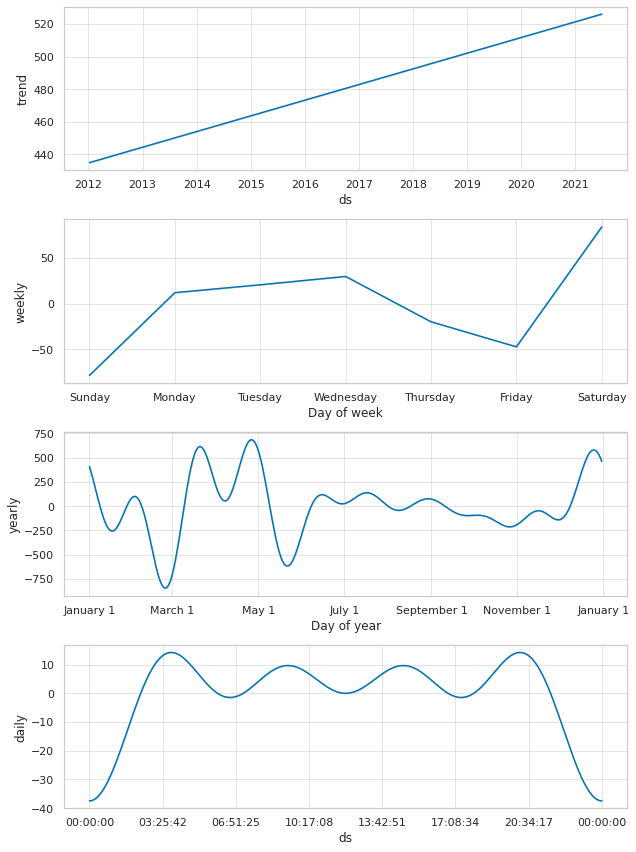

In [107]:
m6.plot_components(predictions6)
plt.show()

In [108]:
#vitesse du vent

dfV = Pop[["Date","Rafales (vitesse du vent) en km/h"]]

dfV['ds'] = pd.to_datetime(dfV['Date'],infer_datetime_format=True, dayfirst= True)
dfV['y'] = dfV['Rafales (vitesse du vent) en km/h']
dfV = dfV.drop(["Date","Rafales (vitesse du vent) en km/h"], axis=1)
dfV

,ds,y
354,2012-08-01,44.4
333,2012-10-01,40.7
332,2012-10-02,38.9
353,2012-08-03,42.8
342,2012-09-04,37.0
...,...,...
388,2020-09-11,29.5
19,2020-09-11,29.5
373,2020-11-19,61.2
372,2020-11-20,26.3


In [109]:
m7 = Prophet(daily_seasonality=True)
m7.fit(dfV)

future7 = m7.make_future_dataframe(periods=7, freq='D')
predictions7=m7.predict(future7)

predictions7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,44.172208,29.309059,59.088868
401,2021-06-23,43.818789,28.634125,59.507006
402,2021-06-24,46.208552,31.698403,61.599757
403,2021-06-25,44.229409,28.479448,59.621359
404,2021-06-26,45.399866,31.039851,59.733734
405,2021-06-27,45.475958,30.557049,60.294793
406,2021-06-28,44.841416,29.477873,59.273515


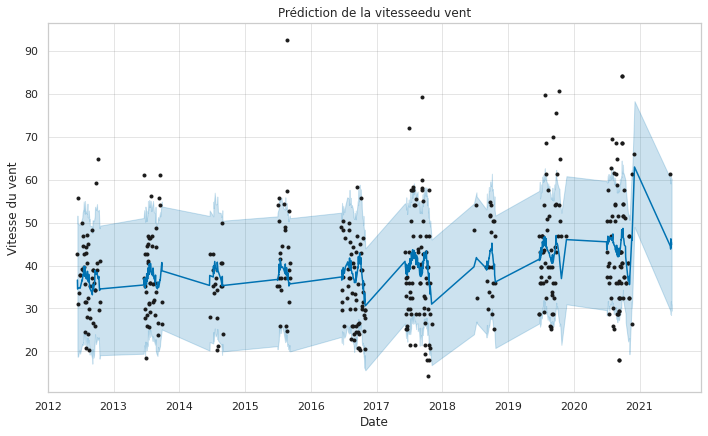

In [110]:
m7.plot(predictions7)
plt.title("Prédiction de la vitesseedu vent")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent")
plt.show()

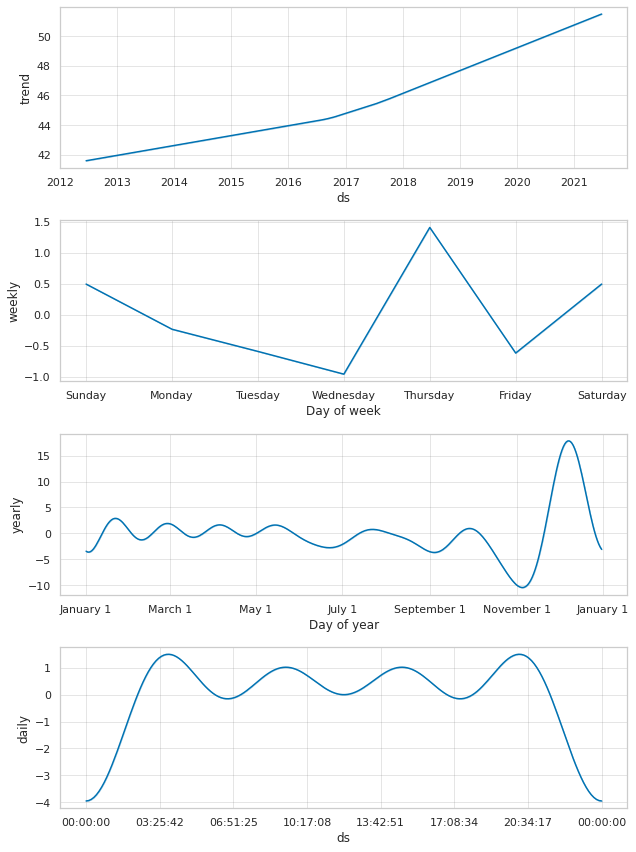

In [111]:
m7.plot_components(predictions7)
plt.show()

**Tableau récapitulatif des prédictions**

In [118]:
predictions7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,44.172208,29.309059,59.088868
401,2021-06-23,43.818789,28.634125,59.507006
402,2021-06-24,46.208552,31.698403,61.599757
403,2021-06-25,44.229409,28.479448,59.621359
404,2021-06-26,45.399866,31.039851,59.733734
405,2021-06-27,45.475958,30.557049,60.294793
406,2021-06-28,44.841416,29.477873,59.273515


In [119]:
RTS={'Prix au kilo des tomates dans 7 jours':[1.682, 1.660, 1.677, 1.672, 1.709, 1.706, 1.626],
     'Production de tomates dans 7 jours' :[0.395, 0.154, 0.369, 0.011, 0.027, 0.072, 0.364],
     'Température minimale dans 7 jours': [15.8, 16.2, 16, 15.5, 15.2, 14.9, 13.8],
     'Température maximale dans 7 jours':[28.8, 29.3, 28.5, 28.1, 28.8, 28.5, 27.6],
     'Précipitations dans 7 jours':[1.2, 0.4, 0.4, 0.1, 0.5, 0.5, 1],
     'Ensoleillement dans 7 jours':[579, 578, 519, 483, 607, 440, 526],
     'Vitesse du vent dans 7 jours':[44.2, 43.8, 46.2, 44.2, 45.4, 45.5, 44.8]}
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.682,0.395,15.8,28.8,1.2,579,44.2
2021-06-23,1.660,0.154,16.2,29.3,0.4,578,43.8
2021-06-24,1.677,0.369,16.0,28.5,0.4,519,46.2
2021-06-25,1.672,0.011,15.5,28.1,0.1,483,44.2
2021-06-26,1.709,0.027,15.2,28.8,0.5,607,45.4
2021-06-27,1.706,0.072,14.9,28.5,0.5,440,45.5
2021-06-28,1.626,0.364,13.8,27.6,1.0,526,44.8


**Enregistrement du modèle pour la production**

In [ ]:
import pickle

filename = 'modèle_prophet_Production.pkl'
pickle.dump(m2, open(filename, 'wb'))

In [ ]:
modèle2 = pickle.load(open(filename, 'rb'))
modèle2